## Evaluation of cea results 

In [75]:
import pandas as pd 
import os 

data_dict = {
    "QH_sys_MWhyr": {},
    "E_sys_MWhyr": {}
}
QH_dict = {}
base_path = 'CEA_model/Block0202023'
for year in [2020, 2021, 2022]:   
    path = os.path.join(base_path, str(year), 'outputs', 'data', 'demand', 'Total_demand.csv')
    df = pd.read_csv(path)
    data_dict["QH_sys_MWhyr"][year] = df["QH_sys_MWhyr"].sum()
    data_dict["E_sys_MWhyr"][year] = df["E_sys_MWhyr"].sum()



In [76]:
# Check variable naming: 
# https://city-energy-analyst.readthedocs.io/en/latest/output_methods.html#get-thermal-network-velocity-edges-file # 
# E_sys_MWhyr, End-use total electricity consumption
# QH_sys_MWhyr Total energy demand for heating
data_dict


{'QH_sys_MWhyr': {2020: 940.7660000000001,
  2021: 1067.1819999999998,
  2022: 985.0060000000001},
 'E_sys_MWhyr': {2020: 213.82100000000003,
  2021: 212.27399999999997,
  2022: 212.372}}

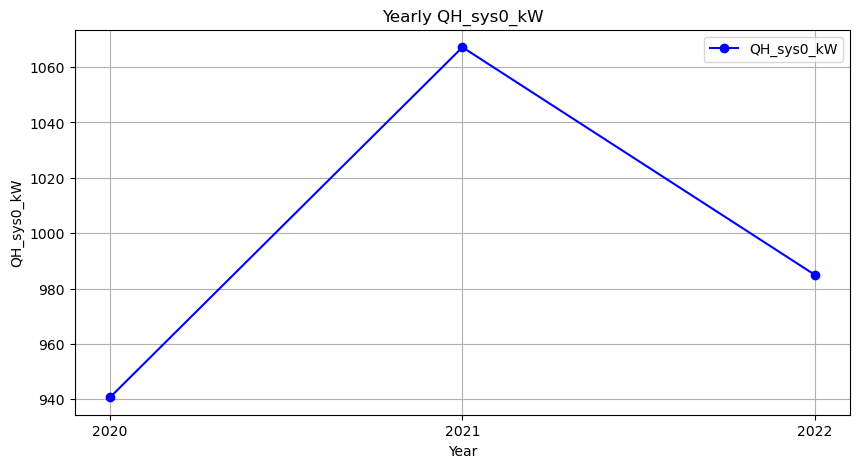

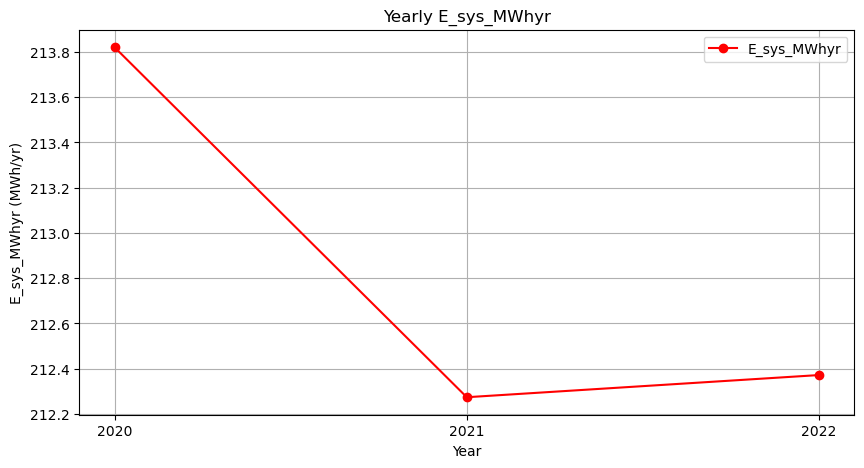

In [38]:
import matplotlib.pyplot as plt

# Provided data
# Extracting data for plotting
years = list(data_dict.keys())
qhsys0_kw_values = [data_dict[year]['QH_sys_MWhyr'] for year in years]
esys_mwhyr_values = [data_dict[year]['E_sys_MWhyr'] for year in years]

# Plotting QH_sys0_kW
plt.figure(figsize=(10, 5))
plt.plot(years, qhsys0_kw_values, marker='o', linestyle='-', color='blue', label='QH_sys0_kW')
plt.title('Yearly QH_sys0_kW')
plt.xlabel('Year')
plt.ylabel('QH_sys0_kW')
plt.xticks(years)
plt.grid(True)
plt.legend()

# Showing the first plot
plt.show()

# Plotting E_sys_MWhyr
plt.figure(figsize=(10, 5))
plt.plot(years, esys_mwhyr_values, marker='o', linestyle='-', color='red', label='E_sys_MWhyr')
plt.title('Yearly E_sys_MWhyr')
plt.xlabel('Year')
plt.ylabel('E_sys_MWhyr (MWh/yr)')
plt.xticks(years)
plt.grid(True)
plt.legend()

# Showing the second plot
plt.show()


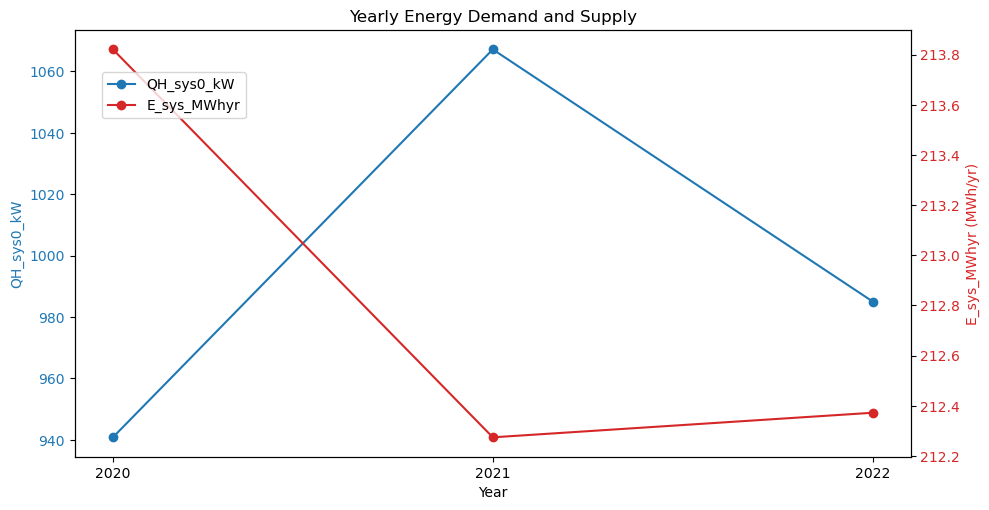

In [39]:
import matplotlib.pyplot as plt

# Provided data

# Extracting data for plotting
years = list(data_dict.keys())
qhsys0_kw_values = [data_dict[year]['QH_sys_MWhyr'] for year in years]
esys_mwhyr_values = [data_dict[year]['E_sys_MWhyr'] for year in years]

# Creating the plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting QH_sys0_kW with ax1
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('QH_sys0_kW', color=color)
ax1.plot(years, qhsys0_kw_values, marker='o', linestyle='-', color=color, label='QH_sys0_kW')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(years)

# Creating a second y-axis for E_sys_MWhyr
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('E_sys_MWhyr (MWh/yr)', color=color)  # we already handled the x-label with ax1
ax2.plot(years, esys_mwhyr_values, marker='o', linestyle='-', color=color, label='E_sys_MWhyr')
ax2.tick_params(axis='y', labelcolor=color)

# Final touches
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Yearly Energy Demand and Supply')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Showing the plot
plt.show()


In [40]:
# Get real data for comparison
# Block: 
elec_path = os.path.join('auxillary', 'Elec_Berlin_2020_2022.xls')
elec_data = pd.read_excel(elec_path)
elec_data

,Blocknummer,Stromverbrauch 2022 [MWh],Hinweis 2022,Stromverbrauch 2021 [MWh],Hinweis 2021,Stromverbrauch 2020 [MWh],Hinweis 2020
0,46079,813.544,-,840.854,-,1076.908,-
1,24177,672.709,-,686.236,-,757.085,-
2,177079,10.313,-,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...
3,39616,106.652,-,116.708,-,111.691,-
4,67643,826.085,-,841.998,-,771.151,-
...,...,...,...,...,...,...,...
16385,78228,100.213,-,101.961,-,98.007,-
16386,74501,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
16387,187017,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
16388,74128,375.105,-,379.125,-,355.516,-


In [41]:
filtered_df = elec_data[elec_data["Blocknummer"] == 20023]

In [84]:
elec_mwhyr = {
    2020: filtered_df["Stromverbrauch 2020 [MWh]"].item(),
    2021 : filtered_df["Stromverbrauch 2021 [MWh]"].item(),
    2022: filtered_df["Stromverbrauch 2022 [MWh]"].item()
}
elec_mwhyr

{2020: 182.027, 2021: 180.491, 2022: 173.854}

In [43]:
# Get real data for comparison
# Block: 
gas_path = os.path.join('auxillary', 'Gas_Berlin_2020_2022.xls')
gas_data = pd.read_excel(gas_path)
gas_data



,Blocknummer,Gasverbrauch 2022 [MWh],Hinweis 2022,Gasverbrauch 2021 [MWh],Hinweis 2021,Gasverbrauch 2020 [MWh],Hinweis 2020
0,46079,1227.315,-,1550.742,-,1385.74,-
1,24177,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...
2,177079,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
3,39616,188.53,-,235.887,-,213.771,-
4,67643,2832.118,-,3333.315,-,2990.835,-
...,...,...,...,...,...,...,...
16385,78228,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...,-,Der Verbrauch wird aus Datenschutzgründen nich...
16386,74501,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
16387,187017,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar,-,Keine Angabe zum Verbrauch verfügbar
16388,74128,991.891,-,1052.222,-,937.367,-


In [44]:
gas_data_filtered = gas_data[gas_data["Blocknummer"] == 20023]

In [81]:
gas_mwhyr = {
    2020: gas_data_filtered["Gasverbrauch 2020 [MWh]"].item(),
    2021 : gas_data_filtered["Gasverbrauch 2021 [MWh]"].item(),
    2022: gas_data_filtered["Gasverbrauch 2022 [MWh]"].item()
}

In [46]:
# Get real data for comparison
# Block: 
dh_path = os.path.join('auxillary', 'DH_Berlin_2020_2022.xls')
dh_data = pd.read_excel(dh_path)


In [47]:
dh_data 

,Blocknummer,Fernwärmeverbrauch 2022 [MWh],Fernwärmeverbrauch 2021 [MWh],Fernwärmeverbrauch 2020 [MWh]
0,1001,-,-,-
1,1002,-,-,-
2,1007,2568.032,2786.803,2684.242
3,1010,-,-,-
4,1012,1305.403,1432.731,1444.354
...,...,...,...,...
16385,195634,-,-,-
16386,195635,-,-,-
16387,195901,-,-,-
16388,195902,-,-,-


In [99]:
dh_data_filtered = dh_data[dh_data["Blocknummer"] == 20023]
dh_data_filtered = dh_data_filtered.replace('-', 0)

In [100]:
dh_mwhyr = {
    2020: dh_data_filtered["Fernwärmeverbrauch 2020 [MWh]"].item(),
    2021 : dh_data_filtered["Fernwärmeverbrauch 2021 [MWh]"].fillna(0).item(),
    2022: dh_data_filtered["Fernwärmeverbrauch 2022 [MWh]"].fillna(0).item()
}
dh_mwhyr

{2020: 851.346, 2021: 0, 2022: 0}

In [62]:
import matplotlib.pyplot as plt 

fig, ax1 = plt.subplot(figsize=(10,5))


AttributeError: Axes.set() got an unexpected keyword argument 'figsize'

<Figure size 640x480 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

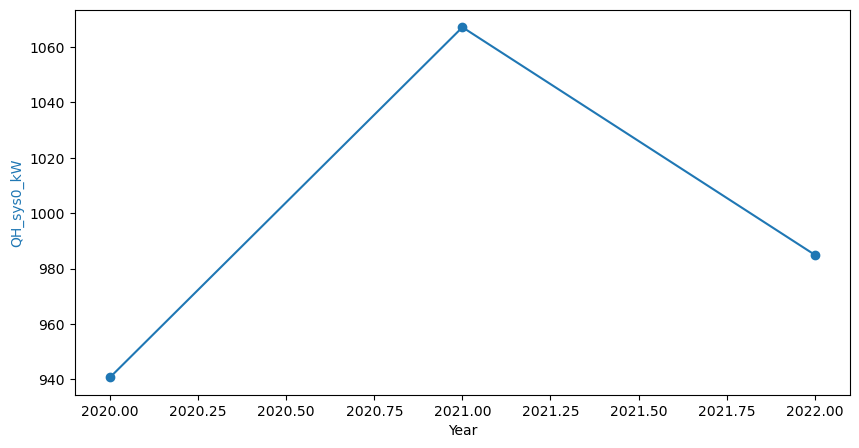

In [60]:
import matplotlib.pyplot as plt


# Extracting data for plotting
years = list(data_dict.keys())
qhsys0_kw_values = [data_dict[year]['QH_sys_MWhyr'] for year in years]
esys_mwhyr_values = [data_dict[year]['E_sys_MWhyr'] for year in years]
real_esys_mwhyr_values = [real_esys_mwhyr[year] for year in years]  # Use the real data extracted
real_gas_data = [gas_mwhyr[year] for year in years]
real_dh_data = [dh_mwhyr[year] for year in years if '-' not in dh_mwhyr[year].values]


# Creating the plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting QH_sys0_kW with ax1
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('QH_sys0_kW', color=color)
ax1.plot(years, qhsys0_kw_values, marker='o', linestyle='-', color=color, label='QH_sys0_kW (Simulated)')
ax1.plot(years, gas_mwhyr, marker="x", linestyle='--', color='tab:blue', label='Gas Consumption (Real)')
ax1.plot(years, dh_mwhyr, marker='x', linestyle=':', color='tab:blue', label='District Heating (Real)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(years)

# Creating a second y-axis for E_sys_MWhyr
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('E_sys_MWhyr (MWh/yr)', color=color)
ax2.plot(years, esys_mwhyr_values, marker='o', linestyle='-', color=color, label='E_sys_MWhyr (Simulated)')
ax2.plot(years, real_esys_mwhyr_values, marker='x', linestyle='--', color='tab:red', label='Electricity Consumption (Real)')
ax2.tick_params(axis='y', labelcolor=color)

# Final touches
fig.tight_layout()
plt.title('Comparison of yearly simulated and measured energy demand')
fig.legend( bbox_to_anchor=(0.0, 0.9))

# Showing the plot
plt.show()



In [ ]:
real_gas_data, real_dh_data

In [ ]:
dh_mwhyr, real_esys_mwhyr, 

TypeError: only size-1 arrays can be converted to Python scalars

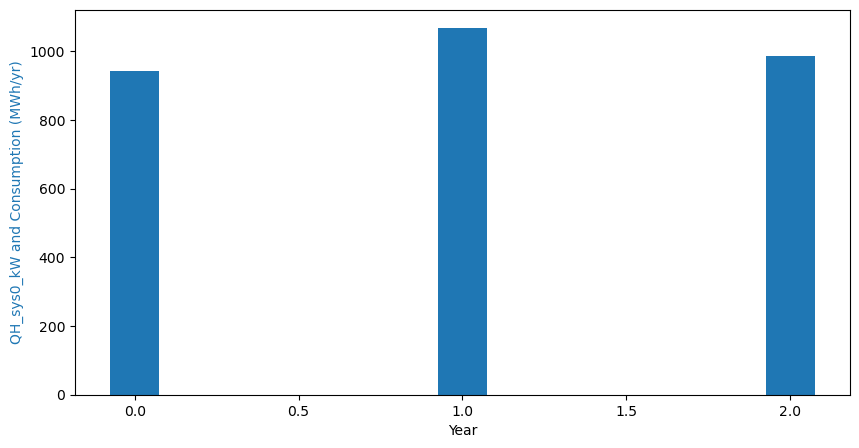

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data_dict, real_esys_mwhyr, gas_mwhyr, and dh_mwhyr are defined as in your context

# Extracting data for plotting
years = list(data_dict.keys())
years_int = range(len(years))  # Convert years to integer indices for plotting
QH_sys_MWhyr_values = [data_dict[year]['QH_sys_MWhyr'] for year in years]
esys_mwhyr_values = [data_dict[year]['E_sys_MWhyr'] for year in years]
real_esys_mwhyr_values = [elec_mwhyr[year].values for year in years]  # Use the real data extracted
real_gas_data = [gas_mwhyr[year] for year in years]
#real_dh_data = [dh_mwhyr[year].values for year in years if '-' not in dh_mwhyr[year].values]

# Creating the plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar width
bar_width = 0.15
# Positions of the bars on the x-axis
r1 = np.arange(len(years_int))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plotting QH_sys0_kW with ax1 using bars
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('QH_sys0_kW and Consumption (MWh/yr)', color=color)
ax1.bar(r1, QH_sys_MWhyr_values, width=bar_width, color=color, label='QH_sys_MWhyr (Simulated)')
ax1.bar(r2, real_gas_data, width=bar_width, color='tab:orange', label='Gas Consumption (Real)')
# ax1.bar(r3, dh_mwhyr, width=bar_width, color='tab:green', label='District Heating (Real)')
ax1.set_xticks([r + bar_width for r in range(len(r1))], years)


# Final touches
fig.tight_layout()
plt.title('Comparison of yearly simulated and measured energy demand')
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Showing the plot
plt.show()


In [65]:
data_dict

{2020: {'QH_sys_MWhyr': 940.7660000000001, 'E_sys_MWhyr': 213.82100000000003},
 2021: {'QH_sys_MWhyr': 1067.1819999999998, 'E_sys_MWhyr': 212.27399999999997},
 2022: {'QH_sys_MWhyr': 985.0060000000001, 'E_sys_MWhyr': 212.372}}

In [74]:
gas_mwhyr, dh_mwhyr,  elec_mwhyr

({2020: 5457    43.37
  Name: Gasverbrauch 2020 [MWh], dtype: object,
  2021: 5457    57.911
  Name: Gasverbrauch 2021 [MWh], dtype: object,
  2022: 5457    34.491
  Name: Gasverbrauch 2022 [MWh], dtype: object},
 {2020: 999    851.346
  Name: Fernwärmeverbrauch 2020 [MWh], dtype: object,
  2021: 999    -
  Name: Fernwärmeverbrauch 2021 [MWh], dtype: object,
  2022: 999    -
  Name: Fernwärmeverbrauch 2022 [MWh], dtype: object},
 {2020: 5455    182.027
  Name: Stromverbrauch 2020 [MWh], dtype: object,
  2021: 5455    180.491
  Name: Stromverbrauch 2021 [MWh], dtype: object,
  2022: 5455    173.854
  Name: Stromverbrauch 2022 [MWh], dtype: object})

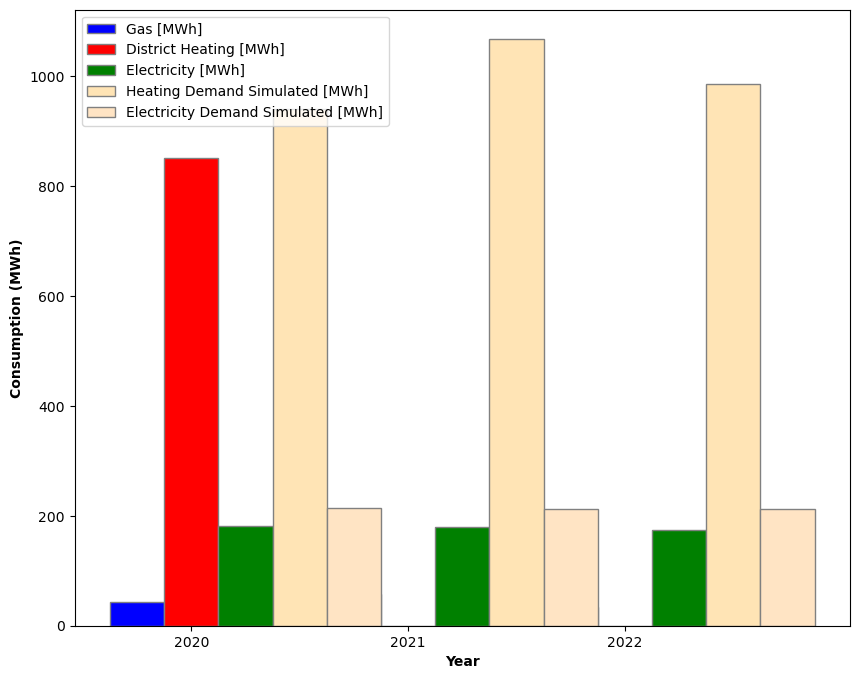

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Years for the x-axis
years = list(gas_mwhyr.keys())

# Values for the y-axis
gas_values = list(gas_mwhyr.values())
dh_values = list(dh_mwhyr.values())
elec_values = list(elec_mwhyr.values())
sim_heating = list(data_dict["QH_sys_MWhyr"].values())
sim_elec = list(data_dict["E_sys_MWhyr"].values())

# Set the width of the bars
bar_width = 0.25

# Set the position of the bars on the x-axis
r1 = np.arange(len(gas_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Make the plot
plt.figure(figsize=(10,8))
plt.bar(r1, gas_values, color='b', width=bar_width, edgecolor='grey', label='Gas [MWh]')
plt.bar(r2, dh_values, color='r', width=bar_width, edgecolor='grey', label='District Heating [MWh]')
plt.bar(r3, elec_values, color='g', width=bar_width, edgecolor='grey', label='Electricity [MWh]')
plt.bar(r4, sim_heating, color='moccasin', width=bar_width, edgecolor='grey', label='Heating Demand Simulated [MWh]')
plt.bar(r5,sim_elec, color='bisque', width=bar_width, edgecolor='grey', label='Electricity Demand Simulated [MWh]')


# Add labels to the x-axis and y-axis
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Consumption (MWh)', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(gas_values))], years)

# Create legend & Show graphic
plt.legend()
plt.show()

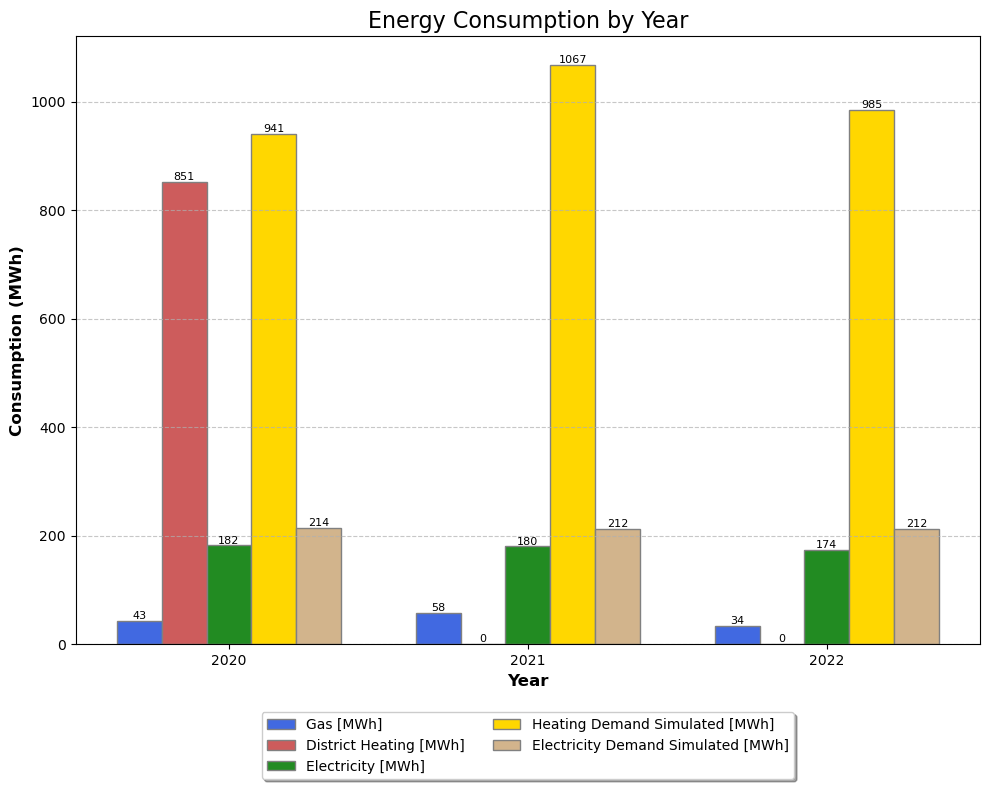

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume the dictionaries 'gas_mwhyr', 'dh_mwhyr', 'elec_mwhyr' and 'data_dict' are already defined as in the original scenario.

# Years for the x-axis
years = list(gas_mwhyr.keys())

# Values for the y-axis
gas_values = list(gas_mwhyr.values())
dh_values = list(dh_mwhyr.values())
elec_values = list(elec_mwhyr.values())
sim_heating = list(data_dict["QH_sys_MWhyr"].values())
sim_elec = list(data_dict["E_sys_MWhyr"].values())

# Set the width of the bars
bar_width = 0.15  # Reduced width to introduce space between bars

# Set the position of the bars on the x-axis
r1 = np.arange(len(gas_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Make the plot
plt.figure(figsize=(10, 8))  # Increased figure size
plt.bar(r1, gas_values, color='royalblue', width=bar_width, edgecolor='grey', label='Gas [MWh]')
plt.bar(r2, dh_values, color='indianred', width=bar_width, edgecolor='grey', label='District Heating [MWh]')
plt.bar(r3, elec_values, color='forestgreen', width=bar_width, edgecolor='grey', label='Electricity [MWh]')
plt.bar(r4, sim_heating, color='gold', width=bar_width, edgecolor='grey', label='Heating Demand Simulated [MWh]')
plt.bar(r5, sim_elec, color='tan', width=bar_width, edgecolor='grey', label='Electricity Demand Simulated [MWh]')

# Add labels to the x-axis and y-axis
plt.xlabel('Year', fontweight='bold', fontsize=12)
plt.ylabel('Consumption (MWh)', fontweight='bold', fontsize=12)
plt.xticks([r + bar_width*2 for r in range(len(gas_values))], years, fontsize=10)

# Create legend & Show graphic
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
plt.title('Energy Consumption by Year', fontsize=16)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optionally, add value labels on top of each bar
for i in range(len(r1)):
    plt.text(r1[i], gas_values[i], str(round(gas_values[i])), ha='center', va='bottom', fontsize=8)
    plt.text(r2[i], dh_values[i], str(round(dh_values[i])), ha='center', va='bottom', fontsize=8)
    plt.text(r3[i], elec_values[i], str(round(elec_values[i])), ha='center', va='bottom', fontsize=8)
    plt.text(r4[i], sim_heating[i], str(round(sim_heating[i])), ha='center', va='bottom', fontsize=8)
    plt.text(r5[i], sim_elec[i], str(round(sim_elec[i])), ha='center', va='bottom', fontsize=8)

# Show graphic
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()
